In [1]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/class_financial-econometrics


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import numpy as np
from creds import FRED_API
import pandas as pd
from pandas_datareader import data as pdr
import random
from statsmodels.tsa.arima_process import ArmaProcess

ModuleNotFoundError: No module named 'creds'

In [3]:
plt.style.use("../styler.mplstyle") 

### Question 3

In [4]:
def simulate_with_armaprocess(phi, theta, T, sigma2=1.0, burnin=800, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    ar = np.r_[1, -np.asarray(phi)]
    ma = np.r_[1,  np.asarray(theta)]
    ap = ArmaProcess(ar, ma)
    x = ap.generate_sample(nsample=T, burnin=burnin,
                           scale=np.sqrt(sigma2),
                           distrvs=rng.standard_normal)
    return x, ap


In [5]:
def sample_acovf(x, max_lag=10):
    x = np.asarray(x)
    n = len(x)
    mean = x.mean()
    gammas = []
    for h in range(max_lag+1):
        cov = np.sum((x[:n-h] - mean) * (x[h:] - mean)) / n
        gammas.append(cov)
    return np.array(gammas)


In [6]:
PARAM = [(1,0), (4,0), (0,1), (0,4), (1,1)]
Ts = [100, 1000, 10000]
SIGMA2 = 1.0
MAX_LAG = 10

In [7]:
OUTDIR = "../Figures/Assignment01"
os.makedirs(OUTDIR, exist_ok=True)


In [12]:
for (p,q) in PARAM:
    # random weights
    phi  = np.random.uniform(0,1,p)
    theta= np.random.uniform(0,1,q)

    for T in Ts:
        # --- simulate via ArmaProcess ---
        x, ap = simulate_with_armaprocess(phi, theta, T, sigma2=SIGMA2, burnin=800)

        g_hat = sample_acovf(x, max_lag=MAX_LAG)
        g_true = ap.acovf(nobs=MAX_LAG+1)

        lags = np.arange(MAX_LAG+1)
        plt.figure(figsize=(7,4.2))
        plt.stem(lags, g_true, label="True ACVF")
        plt.plot(lags, g_hat, label=f"Sample ACVF (T={T})")
        plt.xlabel("Lag")
        plt.ylabel("Autocovariance")
        plt.title(f"ARMA({p},{q}) — Sample vs. True ACVF (T={T})")
        plt.legend()
        plt.tight_layout()


        fname = os.path.join(OUTDIR, f"arma_{p}_{q}_T{T}.png")
        plt.savefig(fname, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"Saved {fname}")

/tmp/ipykernel_204506/1616802649.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_204506/1616802649.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


Saved ../Figures/Assignment01/arma_1_0_T100.png


/tmp/ipykernel_204506/1616802649.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_204506/1616802649.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


Saved ../Figures/Assignment01/arma_1_0_T1000.png
Saved ../Figures/Assignment01/arma_1_0_T10000.png


/tmp/ipykernel_204506/1616802649.py:21: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_204506/1616802649.py:25: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(fname, dpi=150, bbox_inches="tight")


ValueError: The model's autoregressive parameters (ar) indicate that the process
 is non-stationary. arma_acovf can only be used with stationary processes.


### Question 4

In [13]:
df = pdr.DataReader(
    ["GDPC1","CNP16OV","CPIAUCSL","FEDFUNDS","WM2NS"],
    "fred",
    start="1980-01-01",
    end="2025-07-01"
).astype(float)

df['CNP16OV'] =  df['CNP16OV'].astype(float) # Civilian non-instituional population 
df['POP'] = df["CNP16OV"] * 1000.0

df['GDPC1'] = df['GDPC1'].astype(float) # real gdp
df['CPIAUCSL'] = df['CPIAUCSL'].astype(float) # CPI price level
df['FEDFUNDS'] = df['FEDFUNDS'].astype(float) # Fed funds

In [21]:
df = (
    df
    .resample('QE') 
    .agg({
        'GDPC1': 'last',     
        'CPIAUCSL': 'mean',  
        'CNP16OV': 'mean',
        'POP': 'mean',       
        'FEDFUNDS': 'mean',  
        'WM2NS': 'mean'      
    })
    .loc[:'2025-06-30']      
).reset_index()

In [22]:
df["RGDP_per_capita"] = df["GDPC1"] / df["CNP16OV"]
df["YGR"] = 100 * (np.log(df["RGDP_per_capita"]) - np.log(df['RGDP_per_capita'].shift(-1)))
df['INF'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift(-1))

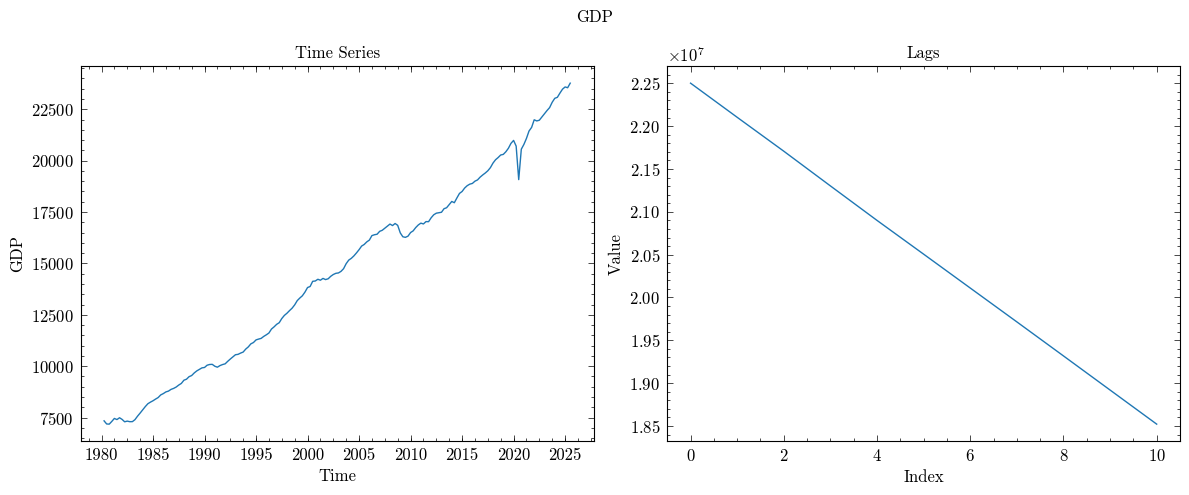

In [24]:
lags = sample_acovf(df['GDPC1'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('GDP')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['GDPC1'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Lags")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'GDP_2.png'))

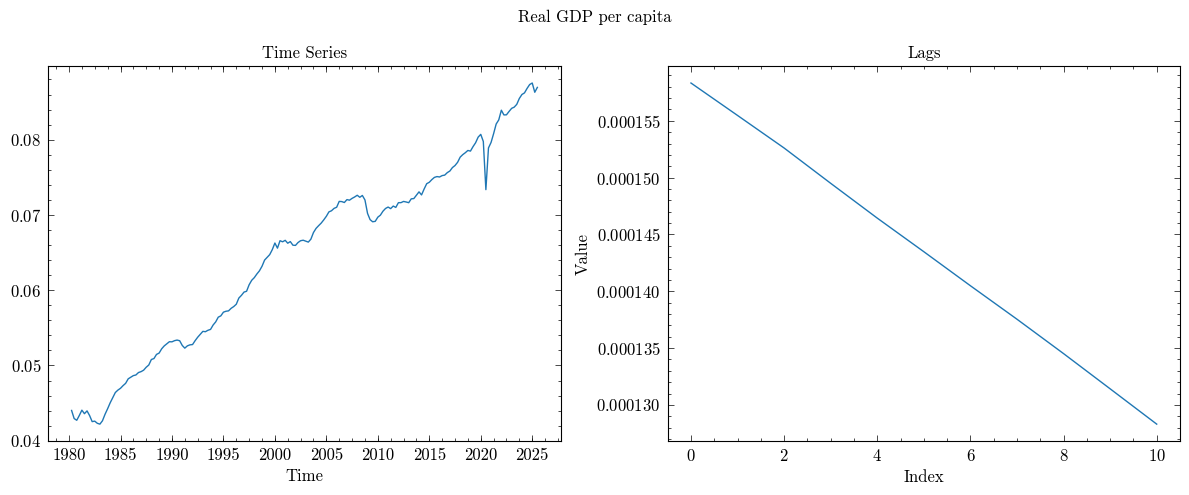

In [26]:
lags = sample_acovf(df['RGDP_per_capita'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Real GDP per capita')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['RGDP_per_capita'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("Real GDP Per Capita")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Lags")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'Real_GDP_2.png'))

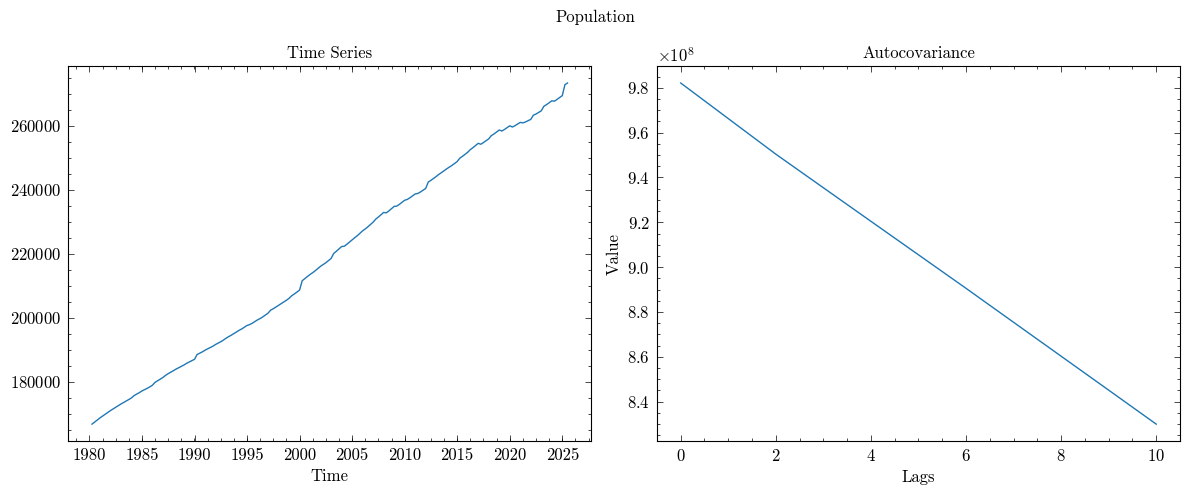

In [27]:
lags = sample_acovf(df['CNP16OV'])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Population')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['CNP16OV'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Value")

plt.savefig(os.path.join(OUTDIR, 'Population_2.png'))
plt.tight_layout()

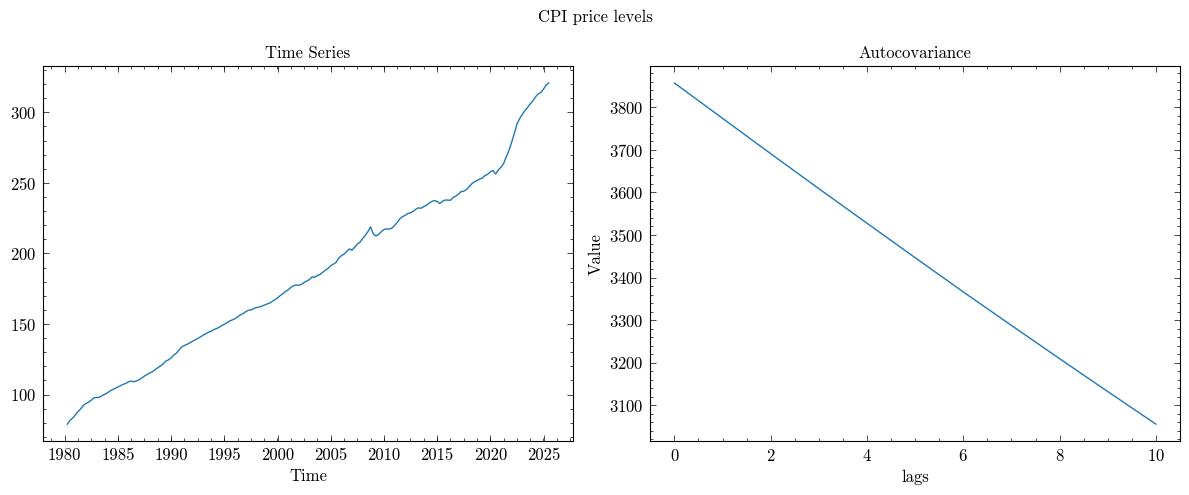

In [28]:
lags = sample_acovf(df['CPIAUCSL'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('CPI price levels')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['CPIAUCSL'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'CPI_2.png'))

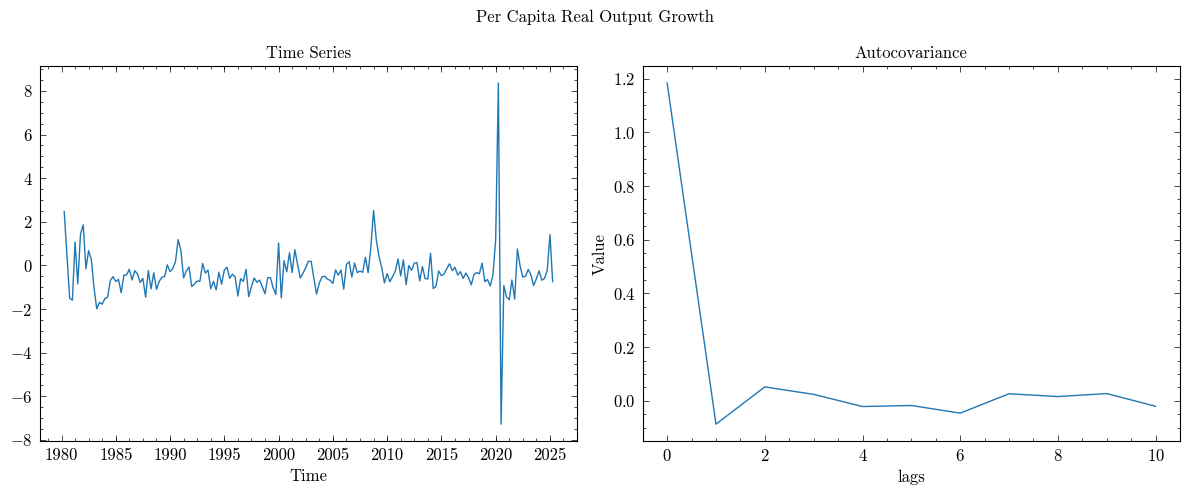

In [29]:
lags = sample_acovf(df['YGR'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Per Capita Real Output Growth')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['YGR'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'YGR_2.png'))

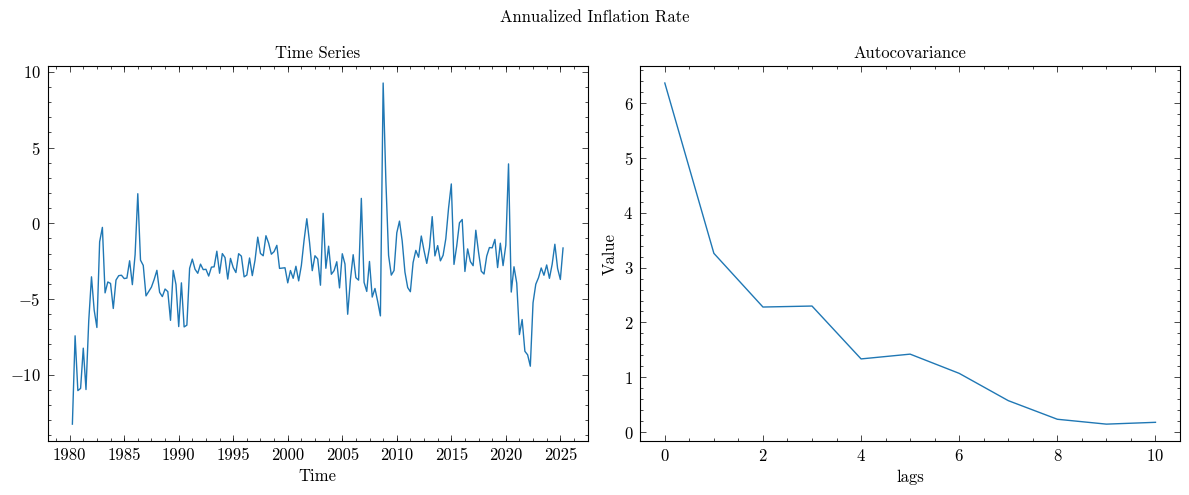

In [30]:
lags = sample_acovf(df['INF'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Annualized Inflation Rate')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['INF'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'INF_2.png'))

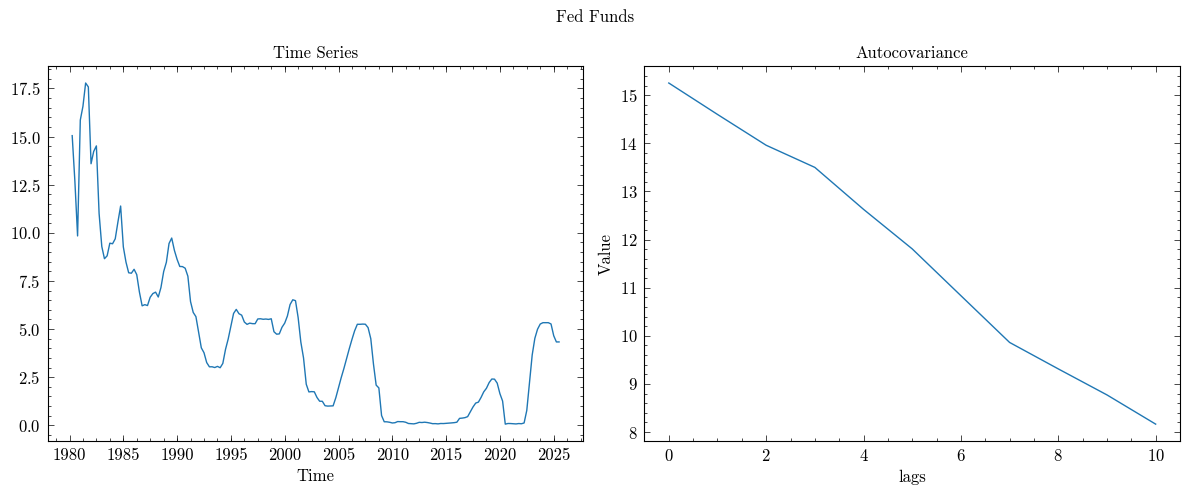

In [31]:
lags = sample_acovf(df['FEDFUNDS'].dropna())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Fed Funds')
# First plot: Real GDP Per Capita
axes[0].plot(df['DATE'], df['FEDFUNDS'])
axes[0].set_title("Time Series")
axes[0].set_xlabel("Time")
# axes[0].set_ylabel("GDP")

# Second plot: lags
axes[1].plot(range(11), lags)
axes[1].set_title("Autocovariance")
axes[1].set_xlabel("lags")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'FED_2.png'))
